In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot

from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

### Загрузка и исследование тренингово датасета

In [40]:
df = pd.read_csv('train.csv')
df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [41]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,7500,NaN,NaN,NaN,3749.5,2165.21,0,1874.75,3749.5,5624.25,7499
Home Ownership,7500,4,Home Mortgage,3637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual Income,5943,NaN,NaN,NaN,1.36639e+06,845339,164597,844341,1.16839e+06,1.64014e+06,1.01493e+07
Years in current job,7129,11,10+ years,2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tax Liens,7500,NaN,NaN,NaN,0.0301333,0.271604,0,0,0,0,7
Number of Open Accounts,7500,NaN,NaN,NaN,11.1309,4.90892,2,8,10,14,43
Years of Credit History,7500,NaN,NaN,NaN,18.3175,7.04195,4,13.5,17,21.8,57.7
Maximum Open Credit,7500,NaN,NaN,NaN,945154,1.60262e+07,0,279230,478159,793502,1.30473e+09
Number of Credit Problems,7500,NaN,NaN,NaN,0.17,0.498598,0,0,0,0,7
Months since last delinquent,3419,NaN,NaN,NaN,34.6926,21.6888,0,16,32,50,118


#### В данных есть пропущенные данные, очевидные выбросы. Почистим их

### Функция очистки датасета

In [42]:
def cleaner(df):
    #Введем справочные значения
    
    MAX_INCOME = 10**7 #Примем, что максимальный приемлемый для анализа доход 10 млн
    MEDIAN_INCOME = 7*10**5 #Примем за средний доход 70 тыс. Ниже среднего и медианного
    
    #В столбце 'Home Ownership' схожие значения: Home Mortgage == Have Mortgage
    #Feature 'Home Ownership' переведем в дамми
    df.loc[(df['Home Ownership'] == 'Have Mortgage'), 'Home Ownership'] = 'Home Mortgage'
    
    #Для annual income почистим верхнюю границу
    df.loc[(df['Annual Income'] > MAX_INCOME), 'Annual Income'] = MAX_INCOME
    #Пустые значения 'Annual Income' заполним MEDIAN_INCOME
    df['Annual Income'].fillna(value=MEDIAN_INCOME, inplace = True)
    
        
    #'Maximum Open Credit' > 2*10**6, we == 2*10**6
    df.loc[(df['Maximum Open Credit'] > 2*10**6), 'Maximum Open Credit'] = 2*10**6
    
    
    #'Credit score' 2 intervals > 750 and < 6000.  The last one we == 751
    df.loc[(df['Credit Score'] > 751), 'Credit Score']=751
    df['Credit Score'].fillna(value=df['Credit Score'].median(), inplace = True)
    
    #'Monthly Debt' > 60000 we = median()
    df.loc[(df['Monthly Debt'] > 60000), 'Monthly Debt'] = 60000
    
    #'Current Credit Balance' > 10**6
    df.loc[(df['Current Credit Balance'] > 10**6), 'Current Credit Balance'] = 10**6
    
    #'Current Loan Amount' == 99999999 is NAN, we = 3*10**5
    df.loc[(df['Current Loan Amount'] > 9*10**7), 'Current Loan Amount'] = 3*10**5
           
    #'Years of Credit History' >40, we = 40
    df.loc[(df['Years of Credit History'] > 40), 'Years of Credit History'] = 40
    
    # 'Number of Open Accounts' > 30, we = 30
    df.loc[(df['Number of Open Accounts'] > 30), 'Number of Open Accounts'] = 30
    
    # 'Tax Liens' for Tax liens Credit Default is the same
    df.loc[(df['Tax Liens'] > 5), 'Tax Liens'] = 5
    
    # for 2 & 1 chi = 0.8 we may unite them
    df.loc[(df['Tax Liens'] == 2), 'Tax Liens'] = 1
    
    # for 0 & 3 chi = 0.28 we may unite them
    df.loc[(df['Tax Liens'] == 3), 'Tax Liens'] = 0
    #at the end we have 0, 1, 4, 5
    
    #Number of credit problems
    # 6 & 7 together
    df.loc[(df['Number of Credit Problems'] > 7), 'Number of Credit Problems'] = 6
    # 4 & 5 together
    df.loc[(df['Number of Credit Problems'] == 5), 'Number of Credit Problems'] = 4
    # 2 & 3 together
    df.loc[(df['Number of Credit Problems'] == 3), 'Number of Credit Problems'] = 2
    # 0 & 1 together
    df.loc[(df['Number of Credit Problems'] == 0), 'Number of Credit Problems'] = 1
        
    #Purpose
    # vacation == take a trip = wedding
    df.loc[((df['Purpose'] == 'wedding')|(df['Purpose'] == 'take a trip')), 'Purpose'] = 'vacation'
    #moving = major purchases = educational exp
    df.loc[((df['Purpose'] == 'major purchase')|(df['Purpose'] == 'educational expenses')), 'Purpose'] = 'moving'
    # reniewable enegry = small buiss = buiss loan
    df.loc[((df['Purpose'] == 'renewable energy')|(df['Purpose'] == 'small business')), 'Purpose'] = 'business loan'
    #others is one group
    df.loc[((df['Purpose'] != 'business loan') & (df['Purpose'] != 'moving')), 'Purpose'] = 'other'
    
    #Binary Term
    df.loc[(df['Term'] == 'Short Term'), 'Term'] = 0
    df.loc[(df['Term'] == 'Long Term'), 'Term'] = 1
    
    #Years in current job, Bankrupcies
    #It seems it have high correlation between each other. I drop it
    df = df.drop(columns=['Years in current job','Months since last delinquent','Bankruptcies'])
    
    #Категориальные признаки переведем в dummy
    
    for colname in ['Tax Liens','Number of Credit Problems', 'Purpose', 'Home Ownership']:
        df[colname] = df[colname].astype('category')
    #comvert to dummies
    df = pd.get_dummies(df)
    
    return df

In [43]:
dfc = cleaner(df)
dfc.describe(include='all').transpose()
#Данные почищены. Пропусков нет

,count,mean,std,min,25%,50%,75%,max
Id,7500.0,3.749500e+03,2165.207842,0.0,1874.75,3749.5,5624.25,7499.0
Annual Income,7500.0,1.228029e+06,799335.442620,164597.0,700000.00,989130.5,1499974.00,10000000.0
Number of Open Accounts,7500.0,1.111667e+01,4.843613,2.0,8.00,10.0,14.00,30.0
Years of Credit History,7500.0,1.827091e+01,6.872207,4.0,13.50,17.0,21.80,40.0
Maximum Open Credit,7500.0,6.076331e+05,460813.141568,0.0,279229.50,478159.0,793501.50,2000000.0
Term,7500.0,2.592000e-01,0.438225,0.0,0.00,0.0,1.00,1.0
Current Loan Amount,7500.0,3.079776e+05,171418.014069,11242.0,180169.00,300000.0,396929.50,789030.0
Current Credit Balance,7500.0,2.736735e+05,226037.902897,0.0,114256.50,209323.0,360406.25,1000000.0
Monthly Debt,7500.0,1.819561e+04,11351.327585,0.0,10067.50,16076.5,23818.00,60000.0
Credit Score,7500.0,7.244587e+02,24.938356,585.0,718.00,731.0,740.00,751.0


### Определим названия признаков

In [44]:
TARGET_NAME = 'Credit Default'
TN_ID = ['Credit Default', 'Id']
FEATURE_NAMES = dfc.columns.drop(TN_ID).tolist()
FEATURE_NAMES

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Tax Liens_0.0',
 'Tax Liens_1.0',
 'Tax Liens_4.0',
 'Tax Liens_5.0',
 'Number of Credit Problems_1.0',
 'Number of Credit Problems_2.0',
 'Number of Credit Problems_4.0',
 'Number of Credit Problems_6.0',
 'Number of Credit Problems_7.0',
 'Purpose_business loan',
 'Purpose_moving',
 'Purpose_other']

### Нормализация данных

In [45]:
scaler = StandardScaler()

df_norm = dfc.copy()
df_norm[FEATURE_NAMES] = scaler.fit_transform(df_norm[FEATURE_NAMES])

dfc = df_norm.copy()
dfc.head()

,Id,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,...,Tax Liens_4.0,Tax Liens_5.0,Number of Credit Problems_1.0,Number of Credit Problems_2.0,Number of Credit Problems_4.0,Number of Credit Problems_6.0,Number of Credit Problems_7.0,Purpose_business loan,Purpose_moving,Purpose_other
0,0,-0.933265,-0.024088,1.168421,0.169987,-0.591517,-0.046542,-1.001171,-0.905823,0.984145,...,-0.028296,-0.025828,0.14237,-0.131769,-0.046237,-0.0231,-0.011548,-0.146222,-0.090554,0.173023
1,1,-0.253405,0.801797,-0.432336,1.245918,1.690569,-0.250921,0.536665,0.015628,0.502927,...,-0.028296,-0.025828,0.14237,-0.131769,-0.046237,-0.0231,-0.011548,-0.146222,-0.090554,0.173023
2,2,-0.596306,-0.024088,2.434474,1.247445,-0.591517,-0.046542,0.153593,-0.400386,0.703435,...,-0.028296,-0.025828,0.14237,-0.131769,-0.046237,-0.0231,-0.011548,-0.146222,-0.090554,0.173023
3,3,-0.529176,-0.643502,0.615432,-0.998808,-0.591517,-1.088532,-0.786728,-0.604165,-1.221440,...,-0.028296,-0.025828,0.14237,-0.131769,-0.046237,-0.0231,-0.011548,-0.146222,-0.090554,0.173023
4,4,-0.565213,0.388854,-0.679726,-0.481349,-0.591517,-1.062605,-0.797992,-0.970490,-0.218901,...,-0.028296,-0.025828,0.14237,-0.131769,-0.046237,-0.0231,-0.011548,-0.146222,-0.090554,0.173023


### Разбиение на train и test

In [46]:
X = dfc[FEATURE_NAMES]
y = dfc[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

### Балансировка целевой переменной

In [47]:
# Поскольку в целевой переменной доля признаков 1 в разы меньше, чем 0, требуется балансировка

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [48]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4047
1    3156
Name: Credit Default, dtype: int64

In [49]:
# определим тренировачные датасеты на сбалансированных данных
X_train = df_balanced[FEATURE_NAMES]
y_train = df_balanced[TARGET_NAME]

### Построение и оценка моделей

In [50]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [51]:
# CatBoost
model_catb = catb.CatBoostClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                                      silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      4047
           1       0.84      0.68      0.75      3156

   micro avg       0.80      0.80      0.80      7203
   macro avg       0.81      0.79      0.79      7203
weighted avg       0.81      0.80      0.80      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1340
           1       0.58      0.51      0.54       535

   micro avg       0.75      0.75      0.75      1875
   macro avg       0.70      0.68      0.69      1875
weighted avg       0.75      0.75      0.75      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1141  199
1                261  274


### Выберем наиболее важные признаки

In [52]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

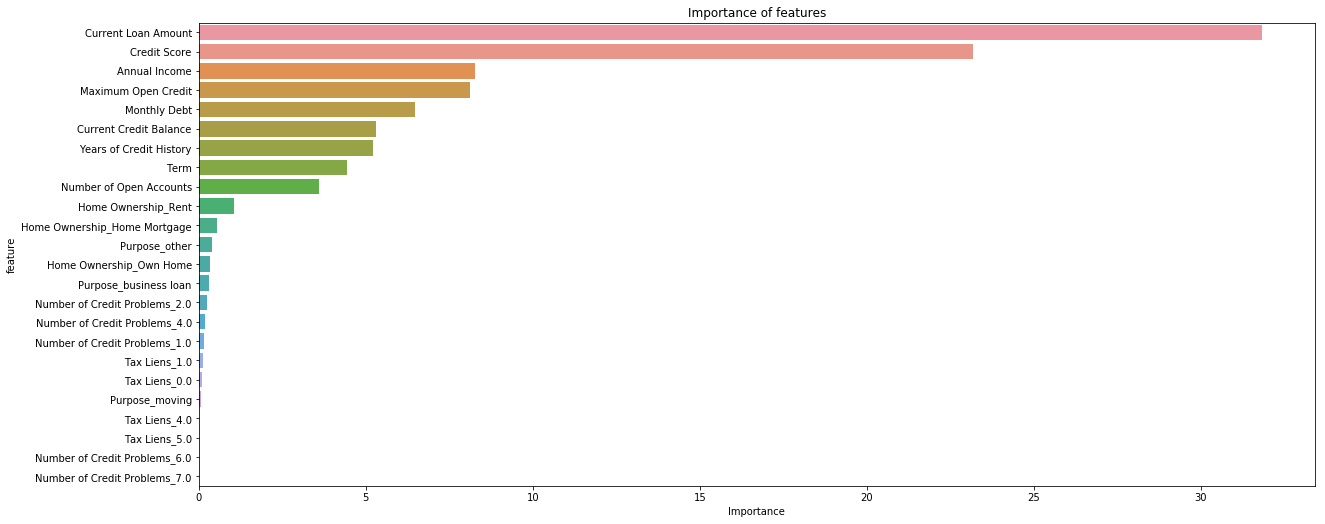

In [53]:
top_features = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [54]:
top_features

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Credit Balance',
 'Years of Credit History',
 'Term',
 'Number of Open Accounts',
 'Home Ownership_Rent',
 'Home Ownership_Home Mortgage',
 'Purpose_other',
 'Home Ownership_Own Home',
 'Purpose_business loan',
 'Number of Credit Problems_2.0']

#### Построим модель на ТОР 15 релевантных признаках

In [55]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=4, learning_rate=0.1,
                                      silent=True, random_state=21)
final_model.fit(X_train[top_features], y_train)

y_train_pred = final_model.predict(X_train[top_features])
y_test_pred = final_model.predict(X_test[top_features])
y_test_pred_probs = final_model.predict_proba(X_test[top_features])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      4047
           1       0.80      0.64      0.71      3156

   micro avg       0.77      0.77      0.77      7203
   macro avg       0.78      0.76      0.76      7203
weighted avg       0.78      0.77      0.77      7203

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1340
           1       0.56      0.54      0.55       535

   micro avg       0.75      0.75      0.75      1875
   macro avg       0.69      0.69      0.69      1875
weighted avg       0.75      0.75      0.75      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1119  221
1                248  287


### Тестирование

In [56]:
test = pd.read_csv('test.csv')
test.shape

(2500, 17)

In [57]:
# prepare data
test_data = cleaner(test)

In [58]:
test_data.describe(include='all').transpose()
#Данные почищены. Пропусков нет

,count,mean,std,min,25%,50%,75%,max
Id,2500.0,8.749500e+03,721.832160,7500.0,8124.75,8749.5,9374.25,9999.0
Annual Income,2500.0,1.225995e+06,806124.667552,106533.0,700000.00,996521.5,1488726.00,10000000.0
Number of Open Accounts,2500.0,1.117040e+01,4.781643,1.0,8.00,10.0,14.00,30.0
Years of Credit History,2500.0,1.827408e+01,7.074991,3.9,13.40,17.0,22.10,40.0
Maximum Open Credit,2500.0,6.151947e+05,471339.939747,0.0,278586.00,478676.0,802598.50,2000000.0
Term,2500.0,2.556000e-01,0.436285,0.0,0.00,0.0,1.00,1.0
Current Loan Amount,2500.0,3.113598e+05,171521.508622,15422.0,187126.50,300000.0,398893.00,789096.0
Current Credit Balance,2500.0,2.718257e+05,224244.150567,0.0,110114.50,207385.0,366348.50,1000000.0
Monthly Debt,2500.0,1.818271e+04,11140.769524,93.0,10024.75,16642.5,24146.00,60000.0
Credit Score,2500.0,7.244792e+02,24.800411,585.0,717.00,731.0,741.00,751.0


In [59]:
#Нормализация данных
test_norm = test_data.copy()
test_norm[FEATURE_NAMES] = scaler.fit_transform(test_norm[FEATURE_NAMES])

test_data = test_norm.copy()
test_data.head()

,Id,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,...,Tax Liens_4.0,Tax Liens_5.0,Number of Credit Problems_1.0,Number of Credit Problems_2.0,Number of Credit Problems_4.0,Number of Credit Problems_6.0,Number of Credit Problems_7.0,Purpose_business loan,Purpose_moving,Purpose_other
0,7500,-0.652629,-0.453993,-0.816289,-0.836563,-0.585973,-0.868227,-0.740054,-1.020754,0.262984,...,-0.020004,-0.034662,0.132291,-0.120873,-0.044766,-0.020004,-0.020004,-0.119159,-0.072299,0.139914
1,7501,-1.233502,-1.081518,2.039410,-1.186746,-0.585973,-1.359062,-1.007089,-1.424307,-1.027576,...,-0.020004,-0.034662,0.132291,-0.120873,-0.044766,-0.020004,-0.020004,-0.119159,13.831402,-7.147261
2,7502,-0.091140,-0.244818,-0.646643,-0.871297,-0.585973,-0.648338,-0.559037,0.049045,1.069583,...,-0.020004,-0.034662,0.132291,-0.120873,-0.044766,-0.020004,-0.020004,-0.119159,-0.072299,0.139914
3,7503,-0.007050,1.010231,-0.180118,-0.337176,-0.585973,-0.548016,-0.261493,0.841788,0.585624,...,-0.020004,-0.034662,0.132291,-0.120873,-0.044766,-0.020004,-0.020004,-0.119159,-0.072299,0.139914
4,7504,1.383384,-0.035643,0.752932,1.256409,1.706565,2.719003,0.684950,2.192593,-0.745266,...,-0.020004,-0.034662,0.132291,-0.120873,-0.044766,-0.020004,-0.020004,-0.119159,-0.072299,0.139914


In [61]:
X_t = test_data[top_features]


In [62]:
test[TARGET_NAME] = final_model.predict(X_t)

In [64]:
# Проверяем целостность получившихся данных
test.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,2500,NaN,NaN,NaN,8749.5,721.832,7500,8124.75,8749.5,9374.25,9999
Home Ownership,2500,3,Home Mortgage,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual Income,2500,NaN,NaN,NaN,1.226e+06,806125,106533,700000,996522,1.48873e+06,1e+07
Years in current job,2414,11,10+ years,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tax Liens,2500,NaN,NaN,NaN,0.0276,0.235925,0,0,0,0,5
Number of Open Accounts,2500,NaN,NaN,NaN,11.1704,4.78164,1,8,10,14,30
Years of Credit History,2500,NaN,NaN,NaN,18.2741,7.07499,3.9,13.4,17,22.1,40
Maximum Open Credit,2500,NaN,NaN,NaN,615195,471340,0,278586,478676,802598,2e+06
Number of Credit Problems,2500,NaN,NaN,NaN,1.0248,0.237081,1,1,1,1,7
Months since last delinquent,1142,NaN,NaN,NaN,34.1813,22.0243,0,16,30,50,82


In [65]:
smp = pd.read_csv('sampleSubmission.csv')
smp.head()

,Id,Credit Default
0,7500,0
1,7501,0
2,7502,0
3,7503,0
4,7504,0


In [71]:
test['Credit Default'] = test['Credit Default'].astype('int')

In [72]:
test.loc[:, ['Id', 'Credit Default']].to_csv('SKozina_predictions.csv', index = False)

In [73]:
subm = pd.read_csv('SKozina_predictions.csv')
subm.head()

,Id,Credit Default
0,7500,0
1,7501,1
2,7502,1
3,7503,0
4,7504,0
